In [1]:
import sys  
sys.path.append('../scripts/')
from mcl import *
from kf import * 

In [2]:
"""
推定ランドマーク
今回はFastSLAMをもちい観測したランドマークの位置を推定する。
(一般的には壁等を推定しその場所をマップに保存するが、今回はランドマークの位置を推定する。)
"""
class EstimatedLandmark(Landmark):
    """
    推定ランドマークの初期化
    """
    def __init__(self):
        super().__init__(0,0) 
        self.cov = None #
    """
    推定ランドマークの位置を推定し、推定した位置を描画する。
    平均値を青色の★で描画、3σ範囲を楕円で描画
    """
    def draw(self, ax, elems): 
        #self.cov==None 描画するものが無いため描画処理をおこなわない。
        if self.cov is None:
            return
        
        ###推定位置に青い星を描く###
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")#青い星の設定(表示位置(姿勢)、ラベル名、色)
        elems.append(c)#青い星を追加する
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))
        
        ###誤差楕円を描く###
        e = sigma_ellipse(self.pos, self.cov, 10)#表示する楕円(ランドマークの存在確率を示すガウス分布)を追加
        elems.append(ax.add_patch(e))

In [3]:
"""
FastSLAM用パーティクル
パーティクルに地図情報を載せる。
"""
class MapParticle(Particle):  
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        self.map = Map()#パーティクルに地図を持たせる
        #ランドマークの情報を入れるクラスをランドマークの数だけ用意する。
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())
    """
    FastSLAMの式をもちい、観測したランドマークの位置を推定する。
    はじめて観測したランドマークの場合、共分散行列と姿勢の初期化をおこなう。
    """ 
    def init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev):
        #
        x, y, t = self.pose
        ell, phi = z
        mx, my = ell*math.cos(t + phi) + x, ell*math.sin(t + phi) + y
        #Hを計算:hをパーティクルにある地図情報(今回の場合ランドマークの姿勢)で偏微分したもの
        H = np.array([[(mx - x)/math.sqrt(ell), (my - y)/math.sqrt(ell)], 
                                [                     (y - my)/ell,                   (mx - x)/ell]])
        #Qを計算:ロボットとランドマーク間の距離と向きの共分散行列
        Q = np.diag(np.array([(distance_dev_rate*ell)**2, direction_dev**2]))
        #初回はランドマークの姿勢は観測値をそのまま使用。共分散分散は、(H^-1 Q H)^-1で計算
        landmark.cov = np.linalg.inv(H.T.dot( np.linalg.inv(Q) ).dot(H))
        landmark.pos = np.array([mx, my]).T
    """
    FastSLAMの式をもちい、観測したランドマークの位置を推定する。
    """ 
    def observation_update_landmark(self, landmark, z, distance_dev_rate, direction_dev):  ###fastslam7
        """
        観測したランドマークをロボット座標系に変換する。
        極座標表示
        """
        x, y, _ = self.pose#ロボットの姿勢
        mx, my =  landmark.pos#観測したランドマークの姿勢
        estm_z = IdealCamera.relative_polar_pos(self.pose, landmark.pos)#ロボット座標系でのランドマークの姿勢を計算
        estm_ell, _ = estm_z
        #ロボットとランドマークが極端に近い場合は計算しない
        if estm_ell < 0.01:
            return
        """
        ランドマークの観測結果からランドマークの姿勢を推定する。
        
        """
        #Hを計算:hをパーティクルにある地図情報(今回の場合ランドマークの姿勢)で偏微分したもの
        H = np.array([[(mx - x)/math.sqrt(estm_ell), (my - y)/math.sqrt(estm_ell)],  [(y - my)/estm_ell, (mx - x)/estm_ell]])
        #Qを計算:ロボットとランドマーク間の距離と向きの共分散行列
        Q = np.diag(np.array([(distance_dev_rate*estm_ell)**2, direction_dev**2]))
        #カルマンゲインの計算
        K = landmark.cov.dot(H.T).dot( np.linalg.inv(Q + H.dot(landmark.cov).dot(H.T)) )
        
        ###重みの更新#
        Q_z = H.dot(landmark.cov).dot(H.T) + Q　#重みを更新した時の分散を計算
        self.weight *= multivariate_normal(mean=estm_z, cov=Q_z).pdf(z)#正規分布に基づき重みを計算(平均estm_z、分散Q_z)
        
        ###ランドマークの推定の更新###
        landmark.pos = K.dot(z - estm_z) + landmark.pos#カルマンフィルタの更新ステップと同じ
        landmark.cov = (np.eye(2) - K.dot(H)).dot(landmark.cov)#推定後の分散を求める。
    """
    ランドマークを観測し、パーティクルの尤度を計算する。
    パーティクルの計算自体は初回はself.init_landmark_estimationで、2回目以降はself.observation_update_landmarkでおこなう。
    """ 
    def observation_update(self, observation, distance_dev_rate, direction_dev): 
        #観測したランドマークの数だけパーティクルの尤度計算に反映させる
        for d in observation:
            #ランドマークの情報を引き出す
            z = d[0]#ランドマークの姿勢を取得
            landmark = self.map.landmarks[d[1]]#観測したランドマークの内一つを取り出す
            #初回一回名はself.init_landmark_estimationで尤度を更新する、(landmark.covは初期状態ではNone)
            if landmark.cov is None:
                self.init_landmark_estimation(landmark, z, distance_dev_rate, direction_dev)
            else:
                self.observation_update_landmark(landmark, z, distance_dev_rate, direction_dev)

In [4]:
class FastSlam(Mcl):
    def __init__(self, particle_num, init_pose, landmark_num, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05):
        super().__init__(None, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
       
        self.particles = [MapParticle(init_pose, 1.0/particle_num, landmark_num) for i in range(particle_num)]#FastSLAM用パーティクルを用意
        self.ml = self.particles[0]#再尤のパーティクルを上の行で生成したパーティクルのリストの先頭にする
    """
    観測したランドマークをパーティクルフィルタのパーティクルの尤度に反映させる。
    """
    def observation_update(self, observation):  
        #パーティクルの数だけ繰り返す
        for p in self.particles:
            #観測したランドマークをもちい、パーティクルの重みを更新する。
            p.observation_update(observation, self.distance_dev_rate, self.direction_dev) #self.mapを削除
        self.set_ml()#もっとも高い尤度を持つパーティクルの姿勢をロボットの姿勢とする。
        self.resampling() #パーティクルをリサンプリングする
    """
    パーティクルの姿勢を描画する。
    """  
    def draw(self, ax, elems):
        super().draw(ax, elems)
        self.ml.map.draw(ax, elems)

In [5]:
class FastSlamAgent(MclAgent):
    def __init__(self, time_interval, nu, omega, particle_pose, landmark_num, particle_num=100, \
                 motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        super().__init__(time_interval, nu, omega, particle_pose, None, particle_num, motion_noise_stds)
    
        self.pf = FastSlam(particle_num, particle_pose, landmark_num, motion_noise_stds) 

<IPython.core.display.Javascript object>


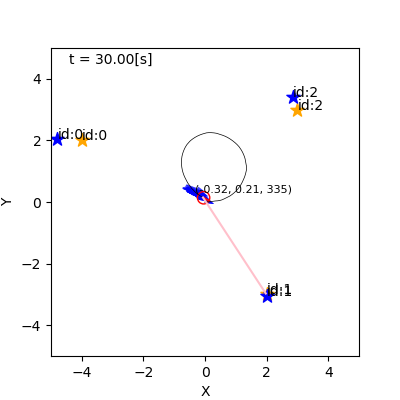

In [6]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    ###真の地図を作成###
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3)]
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
        
    world.append(m)       #ここより上は省略

    ### ロボットを作る ###
    init_pose = np.array([0,0,0]).T
    a = FastSlamAgent(time_interval, 0.2, 10.0/180*math.pi, init_pose, len(m.landmarks))
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

In [7]:
a.pf.particles[10].map.landmarks[2].cov

In [8]:
math.sqrt(0.0025)

0.05